In [18]:
%autosave 100000

Autosaving every 100000 seconds


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
tr_data = pd.read_csv('../input/train.csv')
te_data = pd.read_csv('../input/test.csv')
print('train shape: {}'.format(tr_data.shape))
print('test shape: {}'.format(te_data.shape))
print('train data head:')
tr_data.head()


train shape: (42000, 785)
test shape: (28000, 784)
train data head:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


as we can see the data has 785 columns which are 28*28 pixels +1 labels column (which will only appear in the train data)

In [3]:
print('test data head:')
te_data.head()

test data head:


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


as usual lets separate our training data from the labels

In [5]:
X_train = tr_data.iloc[:,1:].values.astype('float32') # all pixel values
y_train = tr_data.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = te_data.values.astype('float32')

In [9]:
%%time
import xgboost as xgb
params = {'objective':'multi:softprob',
                    'learning_rate':0.2,
                    'subsample':0.8,
                    'colsample_bytree':0.9,
                    'colsample_bylevel':0.7,
                    'max_depth':5,
                    'nthread':4,
                    'eval_metric':'mlogloss',
                    'n_estimators':100,
                    'num_class':10,
                    'seed':1234}
bst_cv = xgb.cv(params=params,dtrain=xgb.DMatrix(X_train,label=y_train),verbose_eval=2,
                nfold=5,early_stopping_rounds=20,num_boost_round=30)


[0]	train-mlogloss:1.69801+0.0032127	test-mlogloss:1.71193+0.00702032
[2]	train-mlogloss:1.1779+0.00332384	test-mlogloss:1.20553+0.00647845
[4]	train-mlogloss:0.883198+0.00420416	test-mlogloss:0.917629+0.00597328
[6]	train-mlogloss:0.688887+0.00174742	test-mlogloss:0.7287+0.00747862
[8]	train-mlogloss:0.554026+0.00224428	test-mlogloss:0.598385+0.00718724
[10]	train-mlogloss:0.4555+0.00216103	test-mlogloss:0.503589+0.00699719
[12]	train-mlogloss:0.38099+0.00226145	test-mlogloss:0.432329+0.00688715
[14]	train-mlogloss:0.323871+0.00305608	test-mlogloss:0.378545+0.00634408
[16]	train-mlogloss:0.278592+0.00306677	test-mlogloss:0.335212+0.0061126
[18]	train-mlogloss:0.24304+0.00233473	test-mlogloss:0.302117+0.00646911
[20]	train-mlogloss:0.214098+0.00200352	test-mlogloss:0.275589+0.00671574
[22]	train-mlogloss:0.190429+0.00209449	test-mlogloss:0.253872+0.00635668
[24]	train-mlogloss:0.170813+0.00181613	test-mlogloss:0.236119+0.00625868
[26]	train-mlogloss:0.153368+0.00155479	test-mlogloss:0.

In [13]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,KFold
knn4 = KNeighborsClassifier(n_jobs=-1,n_neighbors=4)
print(cross_val_score(cv=5,estimator=knn4,X=X_train,y=y_train))

CPU times: user 1h 50s, sys: 2.41 s, total: 1h 52s
Wall time: 16min 8s


In [19]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
gbc = XGBClassifier(objective='multi:softprob',
                    learning_rate=0.2,
                    subsample=0.9,
                    colsample_bytree=1,
                    colsample_bylevel=1,
                    max_depth=3,
                    nthread=4,
                    n_estimators=10,
                    seed=1234)
rfecv = RFECV(estimator=gbc, step=5, cv=5, scoring='neg_log_loss')
rfecv.fit(X_train, y_train)
print("Optimal number of features :{}".format(rfecv.n_features_))
print('rfecv rankings: {}'.format(rfecv.ranking_))

ValueError: Found array with dim 4. Estimator expected <= 2.

now lets try to use only these features for prediction:

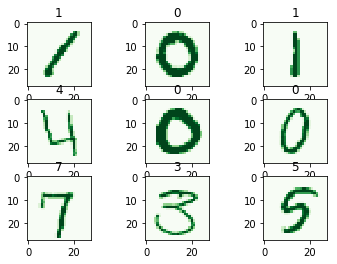

In [6]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('Greens'))
    plt.title(y_train[i])

In [7]:
# add code here to use only selected features



now lets see what NN can get on this data, 
but first we'll have to preprocess it:

In [8]:
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train-train_mean)/train_std
X_text = (X_test-train_mean)/train_std # pay attention that we normalize by train data and not by test data

as we learned, in classification tasks the output of each node in the last layer of the network represent the probability
for each number - this means that we have to one-hot-encode each of the classes so that we will be able to compare the probability for each of the digits.

luckily, keras can easily do that for us:

In [9]:
from keras.utils.np_utils import to_categorical
OHE_y_train = to_categorical(y_train)
num_classes = OHE_y_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)

In [10]:
%%time
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 2s - loss: 0.4233 - acc: 0.8736 - val_loss: 0.3066 - val_acc: 0.9142

In [13]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import Adadelta
model.compile(optimizer=Adadelta(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 2s - loss: 0.6062 - acc: 0.8160 - val_loss: 0.3639 - val_acc: 0.8949

In [15]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 2s - loss: 0.5995 - acc: 0.8118 - val_loss: 0.3349 - val_acc: 0.8995

In [19]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(300, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 6s - loss: 0.2533 - acc: 0.9232 - val_loss: 0.1749 - val_acc: 0.9475

In [20]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 7s - loss: 0.2906 - acc: 0.9127 - val_loss: 0.1562 - val_acc: 0.9543

In [22]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import Adadelta
model.compile(optimizer=Adadelta(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 7s - loss: 0.3456 - acc: 0.8941 - val_loss: 0.1764 - val_acc: 0.9485

In [90]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import Adadelta
model.compile(optimizer=Adadelta(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 20)                6020      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 10)                210       
Total params: 241,730
Trainable params: 241,730
Non-trainable params: 0
_________________________________________________________________
Trai

In [97]:
from keras.layers import Conv2D,MaxPool2D
model= Sequential()
model.add(Conv2D(32,(2,2),activation='relu',input_shape=(28,28,1)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import Adadelta
model.compile(optimizer=Adadelta(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 27, 27, 32)        160       
_________________________________________________________________
dropout_8 (Dropout)          (None, 27, 27, 32)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 23328)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                233290    
Total params: 233,450
Trainable params: 233,450
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 23s - loss: 0.3448 - acc: 0.9020 - val_loss: 0.2183 - val_acc: 0.9393

In [100]:
from keras.layers import Conv2D,MaxPool2D
model= Sequential()
model.add(Conv2D(32,(2,2),activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2),padding='valid'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import Adadelta
model.compile(optimizer=Adadelta(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 27, 27, 32)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)                54090     
Total params: 54,250
Trainable params: 54,250
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 16s - loss: 0.3965 - acc: 0.888

In [101]:
from keras.layers import Conv2D,MaxPool2D
model= Sequential()
model.add(Conv2D(32,(2,2),activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(32,(2,2),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2),padding='valid'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import Adadelta
model.compile(optimizer=Adadelta(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 27, 27, 32)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                54090     
Total params: 58,378
Trainable params: 58,378
Non-trainable params: 0
_________________________________________________________________
Train 

In [131]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False)

model.fit_generator(datagen.flow(X_train, OHE_y_train, batch_size=64),validation_steps=0.2,
                    steps_per_epoch=len(X_train)/20, epochs=10)

Epoch 1/10
2100/2100 [==============================] - 153s - loss: 0.1842 - acc: 0.9452     

KeyboardInterrupt: 

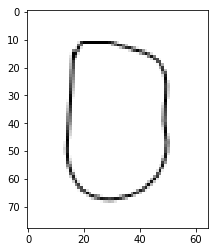

In [118]:
import cv2
img = cv2.imread('../input/zero.png')
plt.imshow(img)

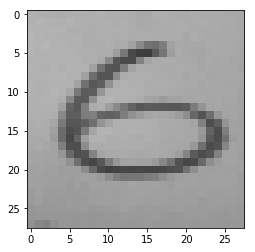

In [112]:
img_resized = cv2.resize(img,(28,28))
plt.imshow(img_resized)

In [113]:
img_reshaped = np.array(img_resized[:,:,0]).reshape(1,28,28,1)


In [116]:
OHE_y_train

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [117]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)